In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

# Aufgabe 14

## a)
Logarithmieren hilft bestimmt. 
Wenn Größenordnung stark verschieden, ist es vielleicht sinnvoller ein kleineres $k$ zu wählen um vorzubeugen, dass in den großen Sprüngen dazwischen keine Daten liegen und vermeintlicher Noise als richtiger Wert gewertet wird. 

## b) 

Das Lernen wird durch simples Abspeichern der Trainingsdaten implementiert, insofern ist das lernen sehr ineffizient "lazy". Vermutlich wird es mit $n^k$ laufen. In der Anwendung ist das Verfahren dann aber effizient, da es lediglich mit den vorhandenen Daten abgleichen muss, also vermutlich sogar je nach Implementierung mit $log(n)$. 

## c) 
Im Folgenden wird ein k-NN Algorithmus implementiert. Dabei wurde sich an die vorgegebene Klassenstruktur nach der `class_structure.py`-Datei gehalten. Mit der `fit`-Funktion werden die Trainingsdaten im Klassenobjekt gespeichert. 
In der `predict`-Funktion werden neuen Daten jeweils Labels zugeordnet. 

In [2]:
from collections import Counter
class KNN:
    '''KNN Classifier.

    Attributes
    ----------
    k : int
        Number of neighbors to consider.
    '''
    def __init__(self, k):
        '''Initialization.
        Parameters are stored as member variables/attributes.
        
        Parameters
        ----------
        k : int
            Number of neighbors to consider.
        '''
        self.k = k

    def fit(self, X, y):
        '''Fit routine.
        Training data is stored within object.
        
        Parameters
        ----------print(back[0])
        X : numpy.array, shape=(n_samples, n_attributes)
            Training data.
        y : numpy.array shape=(n_samples)
            Training labels.
        '''
        # Code
        self.trainingX = X
        self.trainingy = y
    
    def predict(self, X):
        '''Prediction routine.
        Predict class association of each sample of X.
        
        Parameters
        ----------
        X : numpy.array, shape=(n_samples, n_attributes)
            Data to classify.
        
        Returns
        -------
        prediction : numpy.array, shape=(n_samples)
            Predictions, containing the predicted label of each sample.
        '''
        # Code
        prediction= []
        testX = X
        
        for i in range(len(X)): #For Loop für jedes Element der Test Daten
            #Erzeugen eines Arrays mit der Länge des Traingsarrays und in jeder Zeile die gleichen Werte
            k = np.ones(len(self.trainingX))* i 
            k = [int(i) for i in k]
            X = testX[k]
            #Bestimmen der Distanz für jede Zeile also zwischen Trainingsdaten und dem aktuellen Testpunkt
            dist = np.sqrt(np.linalg.norm((X-self.trainingX), axis=1))
            sortdist = np.argsort(dist) #Nur die k-nächsten Elemente werden rausgefiltert
            ksortdist = sortdist[:self.k-1]
            p = self.trainingy[ksortdist] #Label der k-nächsten Elemente wird bestimmt
            prediction = np.append(prediction, Counter(p).most_common(1)[0][0]) #Maximum der Labels wird bestimmt und dem akutellen Testpunkt zugeordnet im predict-Array
        return prediction 


## d)

Der Algorithmus wird auf die `NeutrinoMC.hdf5` Datei angewendet. Dabei wurden die Attribute `Anzahl der Hits`, `x` und `y` betrachtet. Bei den Signalwerten waren aus irgendeinem Grund seehr viele NaNs. Die haben wir dann erstmal rausgefiltert und uns nur an den restlichen 25 Tausend Werten orientiert. 

In [3]:
# get necessary data and get rid of NaN
#Hier lässt sich einstellen, wie viele Werte man jeweils benutzen möchte
train = 5000 #5000
testsignal = 10000 #10000
testbackground = 20000 #20000
#Einlesen der Daten 
signal = pd.read_hdf('NeutrinoMC.hdf5', key="Signal", mode="r") 
signal.head()
sigHits = signal.NumberOfHits.values
sigHits = sigHits[np.logical_not(np.isnan(sigHits))]
sigX = signal.x.values
sigX = sigX[np.logical_not(np.isnan(sigX))] #NaN's rausfiltern..
sigY = signal.y.values
sigY = sigY[np.logical_not(np.isnan(sigY))] 
sig = np.array([sigHits, sigX, sigY]).T #Array mit Hits, x und y erzeugen

#Gleiches für die Background Werte
background = pd.read_hdf('NeutrinoMC.hdf5', key="Background", mode="r")
backHits = background.NumberOfHits.values
backHits = backHits[np.logical_not(np.isnan(backHits))]
backX = background.x.values
backX = backX[np.logical_not(np.isnan(backX))]
backY = background.y.values
backY = backY[np.logical_not(np.isnan(backY))]
back = np.array([backHits, backX, backY]).T

#Trainingsdaten 
TrainX = np.append(sig[:train], back[:train], axis=0) #Trainingspunkte setzen sich aus "train" vielen Signal und Background Werten zusammen, hier also 5000
TrainY = np.append(np.ones(train), np.zeros(train), axis=0)

#Erstellen der Testdaten auf die gleiche Weise
TestX = np.append(sig[train:train+testsignal], back[train:train+testbackground], axis=0)
TestY = np.append(np.ones(testsignal), np.zeros(testbackground), axis=0) #Die dazu gehörenden Labels, 1 für Signal, 0 für Background

#Nutzen unserer Klasse zur Bestimmung der knn Labels
knn = KNN(10)
newfit = knn.fit(TrainX, TrainY)
newlabel = knn.predict(TestX)

#Bestimmung der Reinheit, Effizienz und Signifikanz unserer neuen Labelwerte
def Reinheit(testy, newy): #Test y: Signal = 1, Background = 0
    new_sig = newy[testy==1]
    return len(new_sig[new_sig==1])/len(newy==1)

def Effizienz(testy, newy):
    test_sig, new_sig = testy[testy ==1], newy[testy==1]
    return len(new_sig[new_sig==1])/len(test_sig)

def Signifikanz(testy, newy):
    test_sig, new_sig = testy[testy ==1], newy[testy==1]
    return len(new_sig[new_sig==1])/np.sqrt(len(new_sig))
    
    
rein = Reinheit(TestY, newlabel)*100
eff = Effizienz(TestY, newlabel)*100
signi = Signifikanz(TestY, newlabel)

print(f"Die Reinheit beträgt {rein:.2f} %.\nDie Effizienz beträgt {eff:.2f} %.\nDie Signifikanz beträgt {signi:.2f}.")

Die Reinheit beträgt 32.24 %.
Die Effizienz beträgt 96.71 %.
Die Signifikanz beträgt 96.71.


## e) 

In [4]:
#Das gleiche Verfahren mit log10 Hit Werten 
logsigHits = np.log10(sigHits)
logbackHits = np.log10(backHits)
logSig = np.array([logsigHits, sigX, sigY]).T
logBack = np.array([logbackHits, backX, backY]).T

logTrainX = np.append(logSig[:train], logBack[:train], axis=0)
logTrainY = np.append(np.ones(train), np.zeros(train), axis=0)

logTestX = np.append(logSig[train:train+testsignal], logBack[train:train+testbackground], axis=0)
logTestY = np.append(np.ones(testsignal), np.zeros(testbackground), axis=0)

logknn = KNN(10)
lognewfit = logknn.fit(logTrainX, logTrainY)
lognewlabel = logknn.predict(logTestX)

rein = Reinheit(logTestY, lognewlabel)*100
eff = Effizienz(logTestY, lognewlabel)*100
signi = Signifikanz(logTestY, lognewlabel)

print(f"Die Reinheit beträgt {rein:.2f} %.\nDie Effizienz beträgt {eff:.2f} %.\nDie Signifikanz beträgt {signi:.2f}.")

Die Reinheit beträgt 32.70 %.
Die Effizienz beträgt 98.11 %.
Die Signifikanz beträgt 98.11.


Was sich geändert hat, ist ...

## f) 

In [5]:
#Das gleiche Verfahren mit einem KNN bei dem statt k=10, k=20 gilt
newknn = KNN(20)
newfit2 = newknn.fit(TrainX, TrainY)
newlabel2 = newknn.predict(TestX)

rein = Reinheit(TestY, newlabel2)*100
eff = Effizienz(TestY, newlabel2)*100
signi = Signifikanz(TestY, newlabel2)

print(f"Die Reinheit beträgt {rein:.2f} %.\nDie Effizienz beträgt {eff:.2f} %.\nDie Signifikanz beträgt {signi:.2f}.")

Die Reinheit beträgt 31.95 %.
Die Effizienz beträgt 95.85 %.
Die Signifikanz beträgt 95.85.


Was sich geändert hat, ist ... 

# 15 

## a)
Die beiden Populationen $P0$ und $P1$ werden hier in einem Scatter Plot dargestellt und dazu drei verschiedene Geraden $g_1$, $g_2$ und $g_3$. 

Der Projektionsvektor zu g1 lautet mit passendem 
Vorzeichen (-1.00,-0.00).
Der Projektionsvektor zu g2 lautet mit passendem 
Vorzeichen (-0.80,0.60).
Der Projektionsvektor zu g3 lautet mit passendem 
Vorzeichen (-0.62,0.78).


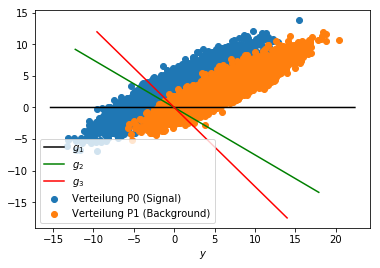

In [6]:
p0 = pd.read_hdf("./zwei_populationen.h5", key="P_0_10000")
p1 = pd.read_hdf("./zwei_populationen.h5", key="P_1")
p0 = p0.values
p1 = p1.values
plt.figure()
plt.scatter(p0[:,0],p0[:,1], label="Verteilung P0 (Signal)")
plt.scatter(p1[:,0], p1[:,1], label="Verteilung P1 (Background)")
plt.xlabel(r"$x$")
plt.xlabel(r"$y$")
x = np.linspace(p0.min()-2, p1.max()+2, 10000)
m1 = np.array([1,0])
m1 = m1/np.linalg.norm(m1)
m2 = np.array([1,-3/4])
m2 = m2/np.linalg.norm(m2)
m3 = np.array([1, -(5/4)])
m3 = m3/np.linalg.norm(m3)
g1 = np.array([x*m1[0], x*m1[1]])
g2 = np.array([x*m2[0], x*m2[1]])
g3 = np.array([x*m3[0], x*m3[1]])

plt.plot(g1[0,:], g1[1,:], "-k", label=r"$g_1$" )
plt.plot(g2[0,:], g2[1,:], "-g", label=r"$g_2$")
plt.plot(g3[0,:], g3[1,:] , "-r", label=r"$g_3$")
plt.legend(loc="best")
None

print(f"Der Projektionsvektor zu g1 lautet mit passendem \nVorzeichen ({-m1[0]:.2f},{-m1[1]:.2f}).")
print(f"Der Projektionsvektor zu g2 lautet mit passendem \nVorzeichen ({-m2[0]:.2f},{-m2[1]:.2f}).")
print(f"Der Projektionsvektor zu g3 lautet mit passendem \nVorzeichen ({-m3[0]:.2f},{-m3[1]:.2f}).")

## b) 

Hier werden die Populationen nun auf die drei Geraden projiziert und für jede Projektion in einem eigenen Histogramm dargestellt.

In [7]:
def proj(p, m):
    return p@m

p0_1 = proj(p0, -m1)
p0_2 = proj(p0, -m2)
p0_3 = proj(p0, -m3)

p1_1 = proj(p1, -m1)
p1_2 = proj(p1, -m2)
p1_3 = proj(p1, -m3)

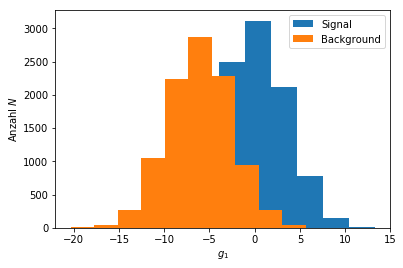

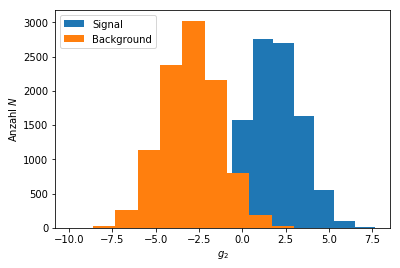

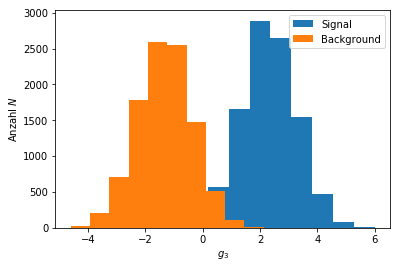

In [8]:
plt.figure(1)
plt.hist(p0_1, label="Signal")
plt.hist(p1_1, label="Background")
plt.xlabel(r"$g_1$")
plt.ylabel(r"Anzahl $N$")
plt.legend(loc="best")
plt.figure(2)
plt.hist(p0_2, label="Signal")
plt.hist(p1_2, label="Background")
plt.xlabel(r"$g_2$")
plt.ylabel(r"Anzahl $N$")
plt.legend(loc="best")
plt.figure(3)
plt.hist(p0_3, label="Signal")
plt.hist(p1_3, label="Background")
plt.xlabel(r"$g_3$")
plt.ylabel(r"Anzahl $N$")
plt.legend(loc="best")

None

## c) 

Hier wird die Verteilung $P0$ als Signal und die Verteilung $P1$ als Background betrachtet. Es wird die Effizienz und die Reinheit des Signals als Funktion eines variablen Schnittes $\lambda_{cut}$ in jeweiligen Plots dargestellt für die verschiedenen Projektionsgeraden.

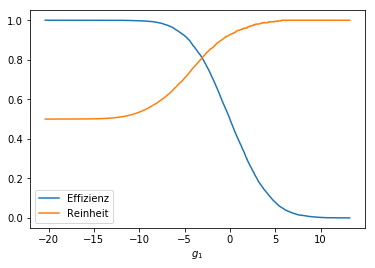

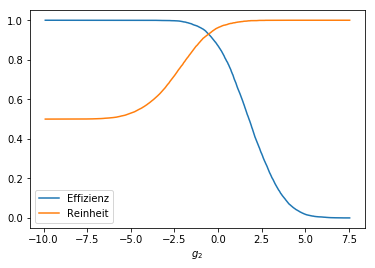

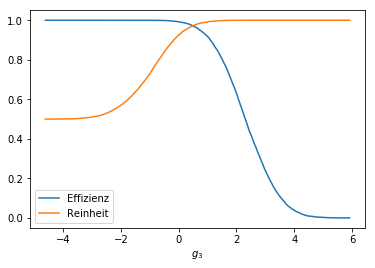

In [9]:
def effizienzSig(lamb, Sig):
    eff = []
    for i in range(len(lamb)):
        eff = np.append(eff, len(Sig[Sig>lamb[i]])/len(Sig)) 
    return eff

def reinheitSig(lamb, Sig, Unt):
    rein = []
    for i in range(len(lamb)):
        rein = np.append(rein, len(Sig[Sig>lamb[i]])/(len(Sig[Sig>lamb[i]])+ len(Unt[Unt>lamb[i]])))
    return rein

def effundrein(p0, p1, num):
    plt.figure(num)
    lambda_eff = np.linspace(np.min([np.min(p0), np.min(p1)]), np.max([np.max(p0), np.max(p1)])-0.1, 10000)
    rein1 = reinheitSig(lambda_eff, p0, p1)
    eff1 = effizienzSig(lambda_eff, p0)

    plt.plot(lambda_eff, eff1, label="Effizienz")
    plt.plot(lambda_eff, rein1, label="Reinheit")
    plt.xlabel(fr"$g_{num}$")
    plt.legend(loc="best")

effundrein(p0_1, p1_1, 1)
effundrein(p0_2, p1_2, 2)
effundrein(p0_3, p1_3, 3)

None

# Aufgabe 16 siehe handschriftliche Notizen

# Aufgabe 17

## a) und b) siehe handschriftliche Notizen

## c)

### Wettervorhersage

Cut:
2
Information Gain:
4.041329369042224e-06
-------------------------------------
Cut:
1
Information Gain:
0.10224760493921947
-------------------------------------
Cut:
0
Information Gain:
0.0031888943740178144
-------------------------------------


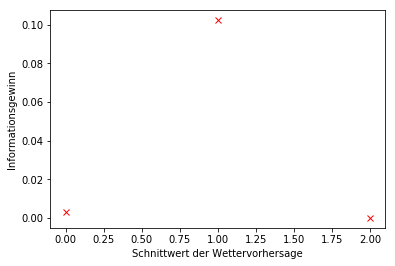

In [10]:
import math
import numpy as np 
import matplotlib.pyplot as plt

#Wettervorhersage Daten
Wetter=np.array([2,2,1,0,0,0,1,2,2,0,2,1,1,0])
#Fußballspielen bei welchem Wetter Daten (0 steht für false und 1 für true)
Data=np.array([[2,2,1,0,0,0,1,2,2,0,2,1,1,0],[0,0,1,1,1,0,1,0,1,1,1,1,1,0]])
#Cutwerte:Doppelte Einträge werden gestrichen weil sonst ünnötiger Rechenaufwand
cut=dict(map(lambda i: (i,1),Wetter)).keys()

#Aufteilen der Werte in über und unter dem Cut Wert 
for i in cut:
    lower=np.array([])
    higher=np.array([])
    for n in range(14):
        if Data[0,n]<=i:
            lower=np.append(lower, Data[1,n]) #Füge hier die Daten ob Fußball gespielt wird hinzu
        else:
            higher=np.append(higher, Data[1,n])

    #Berechnung der Entropien.
    H=0
    H_f=0.94029 #in Teilaufgabe a ausgerechnet
    
    if len(lower[lower==0]) !=0:
        H+=-len(lower)/len(Wetter)*len(lower[lower==0])/len(lower)*math.log2(len(lower[lower==0])/len(lower)) #kein Fußball
    if len(lower[lower==1]) !=0:
        H+=-len(lower)/len(Wetter)*len(lower[lower==1])/len(lower)*math.log2(len(lower[lower==1])/len(lower)) #Fußball
    if len(higher[higher==0]) !=0:
        H+=-len(higher)/len(Wetter)*len(higher[higher==0])/len(higher)*math.log2(len(higher[higher==0])/len(higher))
    if len(higher[higher==1]) !=0:
        H+=-len(higher)/len(Wetter)*len(higher[higher==1])/len(higher)*math.log2(len(higher[higher==1])/len(higher))

    IG=0
    IG=H_f-H
    print('Cut:')
    print(i)
    print('Information Gain:')
    print(IG)
    print('-------------------------------------')
    
    plt.plot(i, IG, 'rx')
    
plt.xlabel('Schnittwert der Wettervorhersage')
plt.ylabel('Informationsgewinn')
plt.show()
    

### Luftfeuchtigkeit

Cut:
85
Information Gain:
0.025082214835219552
-------------------------------------
Cut:
90
Information Gain:
0.010322142239009069
-------------------------------------
Cut:
78
Information Gain:
0.0902803907221339
-------------------------------------
Cut:
96
Information Gain:
4.041329369042224e-06
-------------------------------------
Cut:
80
Information Gain:
0.10224760493921947
-------------------------------------
Cut:
70
Information Gain:
0.014960111258341513
-------------------------------------
Cut:
65
Information Gain:
0.04771315275732946
-------------------------------------
Cut:
95
Information Gain:
0.04771315275732946
-------------------------------------
Cut:
75
Information Gain:
0.0453382133585134
-------------------------------------


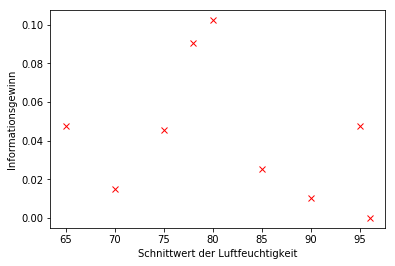

In [11]:
#Luftfeuchtigkeit Daten
Luft=np.array([85, 90, 78, 96, 80, 70, 65, 95, 70, 80, 70, 90, 75, 80])
#Fußballspielen bei welcher Luftfeuchtigkeit
Data=np.array([[85, 90, 78, 96, 80, 70, 65, 95, 70, 80, 70, 90, 75, 80],[0,0,1,1,1,0,1,0,1,1,1,1,1,0]])
#Cutwerte:Doppelte Einträge werden gestrichen weil sonst ünnötiger Rechenaufwand
cut=dict(map(lambda i: (i,1),Luft)).keys()

#Aufteilen der Werte in über und unter dem Cut Wert 
for i in cut:
    lower=np.array([])
    higher=np.array([])
    for n in range(14):
        if Data[0,n]<=i:
            lower=np.append(lower, Data[1,n]) #Füge hier die Daten ob Fußball gespielt wird hinzu
        else:
            higher=np.append(higher, Data[1,n])

    #Berechnung der Entropien.
    H=0
    H_f=0.94029 #in Teilaufgabe a ausgerechnet
    
    if len(lower[lower==0]) !=0:
        H+=-(len(lower)/len(Luft))*((len(lower[lower==0])/len(lower))*math.log((len(lower[lower==0])/len(lower)),2)) #kein Fußball
    if len(lower[lower==1]) !=0:
        H+=-(len(lower)/len(Luft))*((len(lower[lower==1])/len(lower))*math.log(len(lower[lower==1])/len(lower),2)) #Fußball
    if len(higher[higher==0]) !=0:
        H+=-(len(higher)/len(Luft))*((len(higher[higher==0])/len(higher))*math.log(len(higher[higher==0])/len(higher),2))
    if len(higher[higher==1]) !=0:
        H+=-(len(higher)/len(Luft))*((len(higher[higher==1])/len(higher))*math.log(len(higher[higher==1])/len(higher),2))
    
    IG=0
    IG=H_f-H
    print('Cut:')
    print(i)
    print('Information Gain:')
    print(IG)
    print('-------------------------------------')
    
    plt.plot(i, IG, 'rx')
    
plt.xlabel('Schnittwert der Luftfeuchtigkeit')
plt.ylabel('Informationsgewinn')
plt.show()

### Temperatur

Cut:
29.4
Information Gain:
4.041329369042224e-06
-------------------------------------
Cut:
26.7
Information Gain:
0.000493510516392015
-------------------------------------
Cut:
28.3
Information Gain:
0.11340490551047233
-------------------------------------
Cut:
21.1
Information Gain:
0.0453382133585134
-------------------------------------
Cut:
20.0
Information Gain:
0.000493510516392015
-------------------------------------
Cut:
18.3
Information Gain:
0.010322142239009069
-------------------------------------
Cut:
17.8
Information Gain:
0.04771315275732946
-------------------------------------
Cut:
22.2
Information Gain:
0.0013437837338102776
-------------------------------------
Cut:
20.6
Information Gain:
0.014960111258341513
-------------------------------------
Cut:
23.9
Information Gain:
0.025082214835219552
-------------------------------------
Cut:
27.2
Information Gain:
0.010322142239009069
-------------------------------------
Cut:
21.7
Information Gain:
0.001343783733810

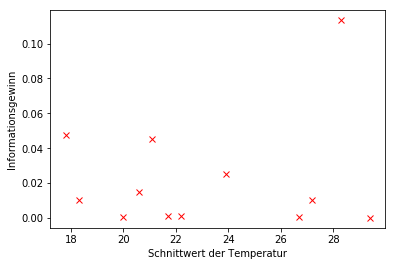

In [12]:
#Temperatur Daten
Temp=np.array([29.4,26.7,28.3,21.1,20,18.3,17.8,22.2,20.6,23.9,23.9,22.2,27.2,21.7])
#Fußballspielen bei welcher Temperatur
Data=np.array([[29.4,26.7,28.3,21.1,20,18.3,17.8,22.2,20.6,23.9,23.9,22.2,27.2,21.7],[0,0,1,1,1,0,1,0,1,1,1,1,1,0]])
#Cutwerte:Doppelte Einträge werden gestrichen weil sonst ünnötiger Rechenaufwand
cut=dict(map(lambda i: (i,1),Temp)).keys()



#Aufteilen der Werte in über und unter dem Cut Wert 
for i in cut:
    lower=np.array([])
    higher=np.array([])
    for n in range(14):
        if Data[0,n]<=i:
            lower=np.append(lower, Data[1,n]) #Füge hier die Daten ob Fußball gespielt wird hinzu
        else:
            higher=np.append(higher, Data[1,n])

    #Berechnung der Entropien.
    H=0
    H_f=0.94029 #in Teilaufgabe a ausgerechnet
    
    if len(lower[lower==0]) !=0:
        H+=-(len(lower)/len(Temp))*((len(lower[lower==0])/len(lower))*math.log((len(lower[lower==0])/len(lower)),2)) #kein Fußball
    if len(lower[lower==1]) !=0:
        H+=-(len(lower)/len(Temp))*((len(lower[lower==1])/len(lower))*math.log(len(lower[lower==1])/len(lower),2)) #Fußball
    if len(higher[higher==0]) !=0:
        H+=-(len(higher)/len(Temp))*((len(higher[higher==0])/len(higher))*math.log(len(higher[higher==0])/len(higher),2))
    if len(higher[higher==1]) !=0:
        H+=-(len(higher)/len(Temp))*((len(higher[higher==1])/len(higher))*math.log(len(higher[higher==1])/len(higher),2))
    
    IG=0
    IG=H_f-H
    print('Cut:')
    print(i)
    print('Information Gain:')
    print(IG)
    print('-------------------------------------')
    
    plt.plot(i, IG, 'rx')
    
plt.xlabel('Schnittwert der Temperatur')
plt.ylabel('Informationsgewinn')
plt.show()

### d)

Der beste Cut ist auf der Temperatur bei einem Wert von 28.3 °C möglich.